In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from collections import Counter
from lightgbm import LGBMClassifier

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
import gensim
import os
import seaborn as sns

In [2]:
df = pd.read_csv("../data/train_with_label.csv")

In [3]:
df['target_probe'] = [getattr(i, f"probe_{int(i.department_id)}") for i in df.itertuples()]
df['accuracy'] = df.label == df.department_id

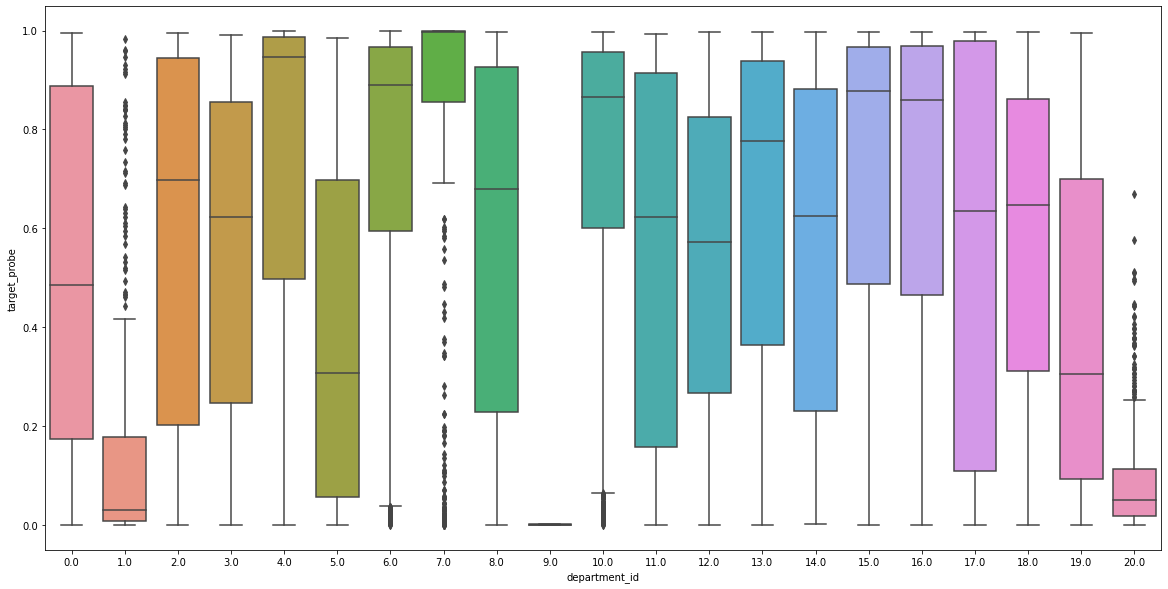

In [4]:
plt.figure(figsize=(20, 10))

ax = sns.boxplot(x="department_id", y="target_probe", data=df)

良い
- 4：酒
- 6：コーヒー・お茶
- 7：ペット食品
- 10：メイクアップコスメ
- 15：乳製品
- 16：日用品・生活用品
- 18：お菓子・つまみ

悪い
- 1：コンビニ
- 5：アジア料理和食
- 9：穀物・シリアル系
- 20：スーパー

In [5]:
pd.DataFrame(df.groupby('department_id')['accuracy'].agg([lambda x: x.sum()/len(x), len]))

,<lambda_0>,len
department_id,,
0.0,0.643035,2003
1.0,0.182482,274
2.0,0.709763,758
3.0,0.741093,842
4.0,0.833017,527
5.0,0.504394,569
6.0,0.877635,2182
7.0,0.833333,486
8.0,0.725511,929


In [147]:
from ipywidgets import interact

@interact(n=(0, 20))
def plot(n):
    print(df.groupby(['department_id', 'label'])['label'].count()[n])

label
0        6
1       18
3        5
4        2
5        1
6       62
7        1
8        5
10    2850
12      72
13       1
14       1
15      21
16     131
17      15
18      54
19       2
20      35
Name: label, dtype: int64


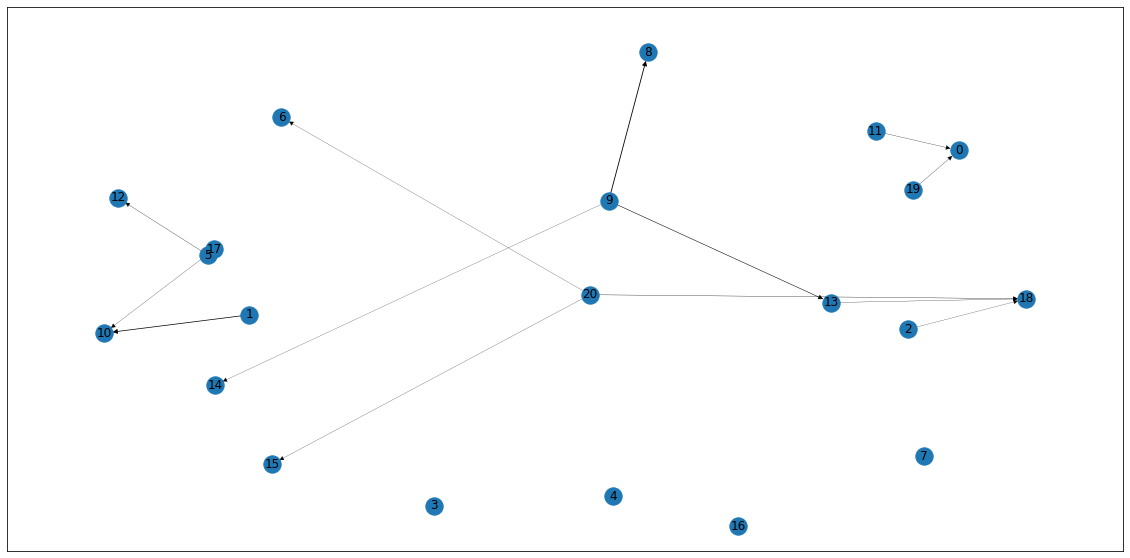

In [37]:
import networkx as nx

plt.figure(figsize=(20, 10))

def get_adj_mat(df, pruning=0.10, reg=True):
    adj = np.zeros([21,21])

    for e in df.loc[:, ['department_id', 'label']].itertuples():
        if e.label != e.department_id:
            adj[int(e.department_id), e.label] += 1 / (df[df.department_id==e.department_id].shape[0] if reg else 1)

    adj[adj <= pruning] = 0
    
    return adj

adj = get_adj_mat(df, pruning=0.1, reg=True)

G  = nx.DiGraph(adj)
edge_width = [ d["weight"]*2 for (u,v,d) in G.edges(data=True)]
nx.draw_networkx(G, width=edge_width)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.,

-  バリエーションが多い方に偏る?

原因検討
- 11,19 -> 0
    - ラベルの意味
        - 0：冷凍食品
        - 11：肉
        - 19：惣菜
    - 3.5~5.0倍ほど0の方がバリエーションが多いため
    - 冷凍食品系キーワードが含まれない場合について検討する

- 5 -> 12
    - ラベルの意味
        - 5：アジア系・和食
        - 12：調味料
    - sourceなど共通の言葉に引っ張られる
    - 5.0倍ほど12の方がバリーエーションが多いため
    - 産地にフォーカスを当て、特に東アジア系の食材の重みを調整する

- 9 -> ...
    - 穀物・シリアル
    - 単純に数が少なすぎる
    - シリアル系の重みを高める

- 1,17 -> 10
    - ラベルの意味
        - 1：コンビニ
        - 17：幼児向け食品・製品幼児向け食品・製品
        - 10：メイクアップ・コスメ・シャンプー
    - 6.0~15.0倍ほど10の方がバリエーションが多いため
    - 差分を探す
    - 17は、キーワード重みを高める

- 13 -> 18
    - ラベルの意味
        - 13：シリアル・木の実
        - 18：菓子つまみ
    - 6.0ほど18の方がバリエーションが多いため
    - 差分を探す

- 20 -> 6,15,18
    - ラベルの意味
        - 20：食品全般
        - 6：コーヒー・お茶
        - 15：乳製品
        - 18：菓子つまみ
    - バリエーションが多く、20のカバー領域が非常に多いため
    - 20はその他領域としてみなす

各クラス検討
- 9：手動のルールベース
- 20：バリエーションがばらつく可能性が高い場合に、20に割り当てる

クラスの構造化を実施する
- 構造化なしクラス
    - 2,3,4,7,8,9,14,16
- 0,11,19
- 5,12
- 1,10,17
- 13,18
- 6,15,18,20